<center>
<img src="" width=600>
</center>
<div style="padding:20px;color:#150d0a;margin:10px;font-size:220%;text-align:center;display:fill;border-radius:20px;border-width: 5px;border-style: solid;border-color: #150d0a;background-color:#eca912;overflow:hidden;font-weight:500">DR Detection utilizing Deep Learning Models and XAI methods</div>

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
1. Importing libraries
2. Load data
3. Confusion Matrix Function
4. Setting up Model
5. Training the model
6. Plotting Model Performance
7. Model Evaluation and Saving
8. Confusion Matrix
9. Validating the Model
10. Sample Predictions
11. Classwise performance score by base model
12. Classwise Accuracy scores

# Importing libraries 📚

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D,Activation,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load data 💾

In [2]:
data_dir=r"Data/train/"
Retanial=[]
for file in os.listdir(data_dir):
    Retanial+=[file]
print(Retanial)
print(len(Retanial))

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
5


In [3]:
train_dir="Data/train"
val_dir="Data/val/"

In [4]:
img_height,img_width=256,256
batch_size=20

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')

val_generator = train_datagen.flow_from_directory(val_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 506 images belonging to 5 classes.
Found 217 images belonging to 5 classes.


In [6]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()

## Confusion Matrix Function

In [7]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Setting up Model

In [8]:
base_model = tf.keras.applications.MobileNet(input_shape=(img_height,img_width, 3), include_top=False,weights='imagenet')
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(5, activation='sigmoid'))
model.summary()

C:\Users\Aditya\AppData\Local\Temp\ipykernel_964\370765580.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(input_shape=(img_height,img_width, 3), include_top=False,weights='imagenet')


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 8, 8, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,295,045 (12.57 MB)

 Trainable params: 3,273,029 (12.49 MB)

 Non-trainable params: 22,016 (86.00 KB)

In [9]:
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 128, 128, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 128, 128, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 128, 128, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 128, 128, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 128, 128, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 128, 128, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 129, 129, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 64, 64, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 64, 64, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 64, 64, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 64, 64, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

# Training the model 🚂

In [10]:
model.compile(optimizer='Adam',loss="categorical_crossentropy",metrics=["accuracy","precision","recall"])
hist=model.fit(train_generator,epochs=40,validation_data=val_generator,verbose=1)

Epoch 1/40


C:\Anaconda\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 970ms/step - accuracy: 0.4341 - loss: 1.6674 - precision: 0.2750 - recall: 0.6495 - val_accuracy: 0.3594 - val_loss: 4.0766 - val_precision: 0.1882 - val_recall: 0.6037
Epoch 2/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 925ms/step - accuracy: 0.7090 - loss: 0.8246 - precision: 0.3880 - recall: 0.8580 - val_accuracy: 0.3364 - val_loss: 5.4518 - val_precision: 0.2028 - val_recall: 0.6083
Epoch 3/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 925ms/step - accuracy: 0.8295 - loss: 0.4848 - precision: 0.4454 - recall: 0.9689 - val_accuracy: 0.2765 - val_loss: 5.1010 - val_precision: 0.2121 - val_recall: 0.5806
Epoch 4/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 923ms/step - accuracy: 0.9012 - loss: 0.3119 - precision: 0.4679 - recall: 0.9837 - val_accuracy: 0.3871 - val_loss: 3.0301 - val_precision: 0.2387 - val_recall: 0.7512
Epoch 5/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 955ms/step - accuracy: 0.9483 - loss: 0.1801 - precision: 0.5131 - recall: 0.9977 - val_accuracy: 0.3963 - val_loss: 3.8142 -

26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 925ms/step - accuracy: 0.9743 - loss: 0.0800 - precision: 0.5402 - recall: 0.9934 - val_accuracy: 0.7650 - val_loss: 1.1321 - val_precision: 0.4037 - val_recall: 0.9078
Epoch 35/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 930ms/step - accuracy: 0.9809 - loss: 0.0555 - precision: 0.5551 - recall: 0.9976 - val_accuracy: 0.8433 - val_loss: 0.5947 - val_precision: 0.5000 - val_recall: 0.9401
Epoch 36/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 927ms/step - accuracy: 0.9970 - loss: 0.0312 - precision: 0.5621 - recall: 1.0000 - val_accuracy: 0.8618 - val_loss: 0.5935 - val_precision: 0.5399 - val_recall: 0.9355
Epoch 37/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 925ms/step - accuracy: 0.9990 - loss: 0.0106 - precision: 0.6056 - recall: 1.0000 - val_accuracy: 0.8525 - val_loss: 0.6288 - val_precision: 0.5531 - val_recall: 0.9355
Epoch 38/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 925ms/step - accuracy: 0.9997 - loss: 0.0109 - precision: 0.6388 - recall: 1.0000 - val_accuracy: 0.8479 - val_loss: 0.62

# Plotting Model Performance  

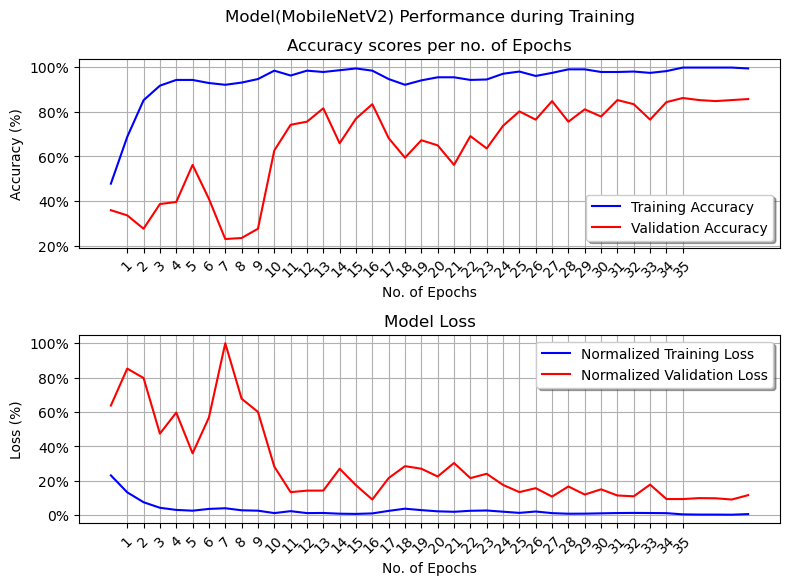

In [16]:
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(2, 1, figsize=(8, 6))

ax[0].plot(hist.history['accuracy'], color='b', label="Training Accuracy")
ax[0].plot(hist.history['val_accuracy'], color='r', label="Validation Accuracy")
ax[0].set_title("Accuracy scores per no. of Epochs")
ax[0].text(0.5, 1.2, "Model(MobileNetV2) Performance during Training", fontsize=12, ha='center', transform=ax[0].transAxes)
ax[0].set_xlabel("No. of Epochs")
ax[0].set_ylabel("Accuracy (%)")
ax[0].yaxis.set_major_formatter(PercentFormatter(1.0))  
x_ticks = list(range(1, 36))  
x_tick_labels = [f"{i}" for i in range(1, 36)]  
ax[0].set_xticks(x_ticks)  
ax[0].set_xticklabels(x_tick_labels, rotation=45)  
ax[0].legend(loc='best', shadow=True)
ax[0].grid(True)

ax[1].set_title("Model Loss")
ax[1].set_xlabel("No. of Epochs")
ax[1].set_ylabel("Loss (%)")


max_loss = max(max(hist.history['loss']), max(hist.history['val_loss']))
normalized_loss = [loss / max_loss for loss in hist.history['loss']]
normalized_val_loss = [val_loss / max_loss for val_loss in hist.history['val_loss']]

ax[1].plot([x * 100 for x in normalized_loss], color='b', label="Normalized Training Loss")
ax[1].plot([x * 100 for x in normalized_val_loss], color='r', label="Normalized Validation Loss")
ax[1].yaxis.set_major_formatter(PercentFormatter(100.0)) 
ax[1].set_xticks(x_ticks)  
ax[1].set_xticklabels(x_tick_labels, rotation=45)  
ax[1].legend(loc='best', shadow=True)
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Model Evaluation and Saving

In [17]:
model.evaluate(val_generator)
model.save('model/Mobilenet.h5')

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.8275 - loss: 0.7961 - precision: 0.4468 - recall: 0.9295


In [18]:
filenames = val_generator.filenames
nb_samples = len(filenames)
model_predict = model.predict(val_generator,steps = nb_samples, verbose=2)

217/217 - 3s - 15ms/step


C:\Anaconda\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


# Confusion Matrix

Confusion matrix, without normalization
[[ 8  6  6  5 14]
 [ 4 11 10 10  8]
 [ 5 17 14  3  9]
 [ 9  8  9 10  9]
 [ 7  8  8 10  9]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

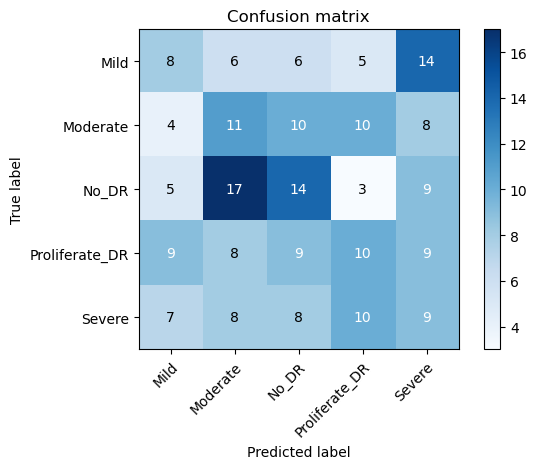

In [19]:
y_true = val_generator.classes
y_pred = model_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe'],title='Confusion matrix')

# Validating the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
[0.10012723 0.01126939 0.9373529  0.99945843 0.9760671 ]


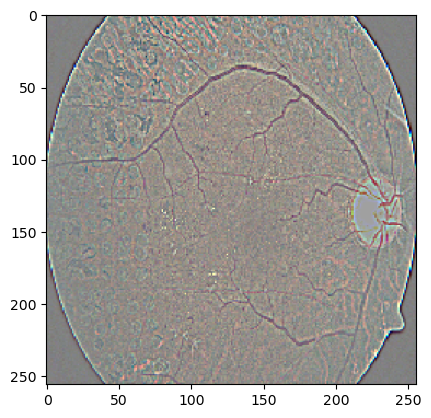

Prediction: Proliferate_DR


In [20]:
from skimage import io
from tensorflow.keras.preprocessing import image

img = image.load_img(r'Data\val\Proliferate_DR\3b232b394e4f.png' , target_size=(img_height,img_width))
show_img=image.load_img(r'Data\val\Proliferate_DR\3b232b394e4f.png', target_size=(img_height,img_width))
Retanial = Retanial
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])


plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',Retanial[ind])

# Training and Validation Data Class Distribution

In [21]:
train_class_counts = train_generator.classes
val_class_counts = val_generator.classes

print("Training Class Distribution:", np.bincount(train_class_counts))
print("Validation Class Distribution:", np.bincount(val_class_counts))


Training Class Distribution: [100 106  90 100 110]
Validation Class Distribution: [39 43 48 45 42]


# Sample Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


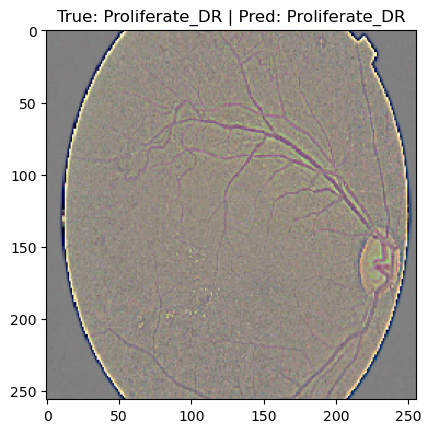

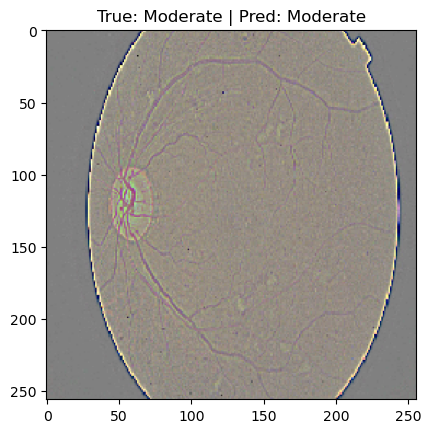

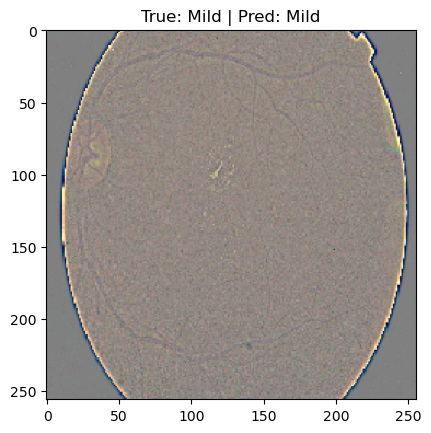

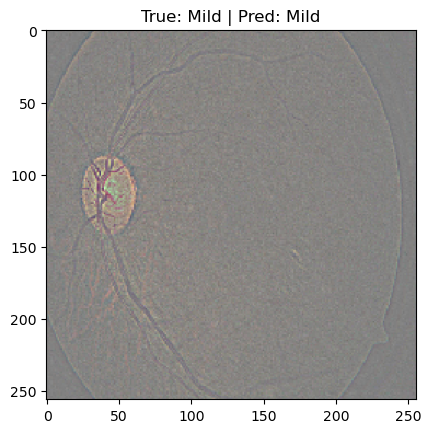

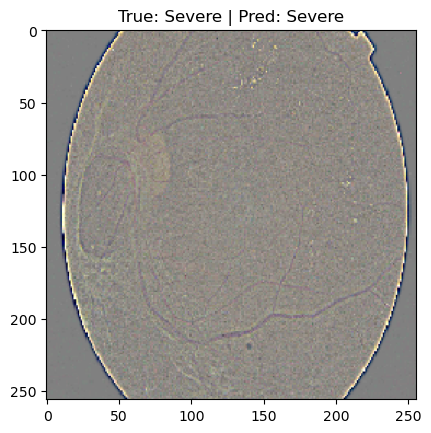

In [22]:
sample_val_images, sample_val_labels = next(val_generator)
predictions = model.predict(sample_val_images)

for i in range(5):
    plt.imshow(sample_val_images[i])
    plt.title(f"True: {Retanial[np.argmax(sample_val_labels[i])]} | Pred: {Retanial[np.argmax(predictions[i])]}")
    plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.8687 - loss: 0.7191 - precision: 0.4755 - recall: 0.9308
Evaluation metrics: [0.7392738461494446, 0.8571428656578064, 0.45190155506134033, 0.9308755993843079]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


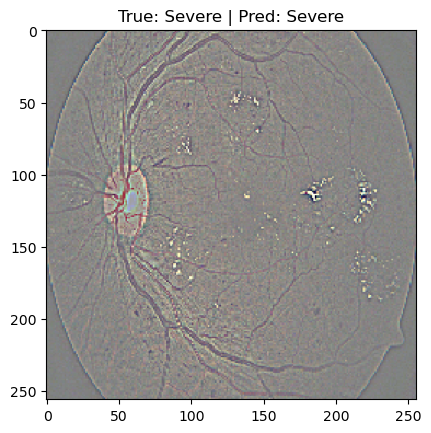

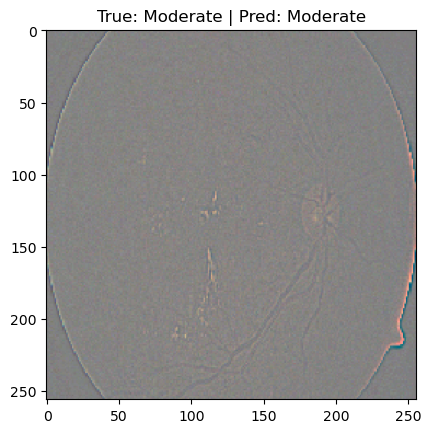

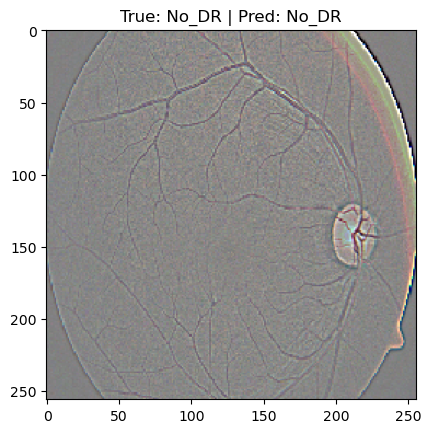

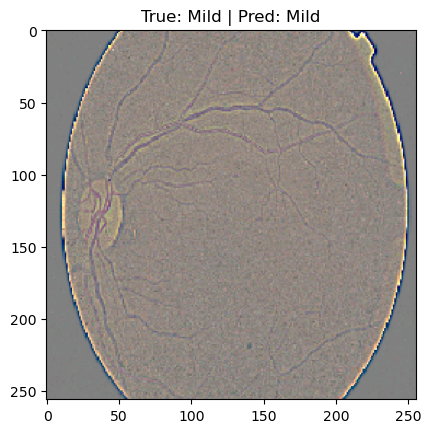

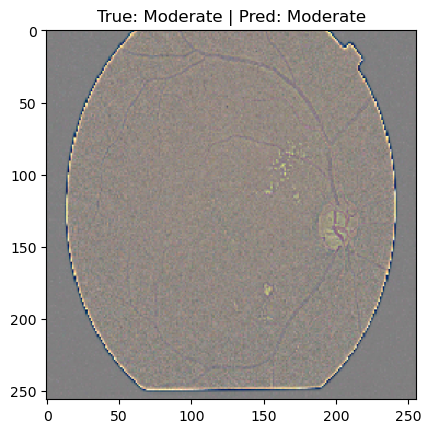

In [23]:
evaluation_metrics = model.evaluate(val_generator)
print("Evaluation metrics:", evaluation_metrics)

sample_val_images, sample_val_labels = next(val_generator)
predictions = model.predict(sample_val_images)

for i in range(5):
    plt.imshow(sample_val_images[i])
    plt.title(f"True: {Retanial[np.argmax(sample_val_labels[i])]} | Pred: {Retanial[np.argmax(predictions[i])]}")
    plt.show()


## Classwise performance score by base model

In [24]:
import numpy as np
from sklearn.metrics import classification_report
def get_predictions_and_labels(model, val_generator):
    predictions = []
    true_labels = []
    num_batches = len(val_generator)
    for i in range(num_batches):
        batch_images, batch_labels = val_generator[i]
        batch_predictions = model.predict(batch_images, verbose=0)
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels)
    return np.array(predictions), np.array(true_labels)

def print_classification_report(model, val_generator, class_names):
    predictions, true_labels = get_predictions_and_labels(model, val_generator)
    print("\nClassification Report:")
    print(classification_report(np.argmax(true_labels, axis=1), 
                              np.argmax(predictions, axis=1), 
                              target_names=class_names))

# Usage:
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferative', 'Severe']
print_classification_report(model, val_generator, class_names)


Classification Report:
               precision    recall  f1-score   support

         Mild       0.97      0.82      0.89        39
     Moderate       0.70      0.81      0.75        43
        No_DR       0.96      0.94      0.95        48
Proliferative       0.92      0.78      0.84        45
       Severe       0.80      0.93      0.86        42

     accuracy                           0.86       217
    macro avg       0.87      0.86      0.86       217
 weighted avg       0.87      0.86      0.86       217



# Classwise Accuracy scores


Overall Model Accuracy: 0.8571 (85.71%)


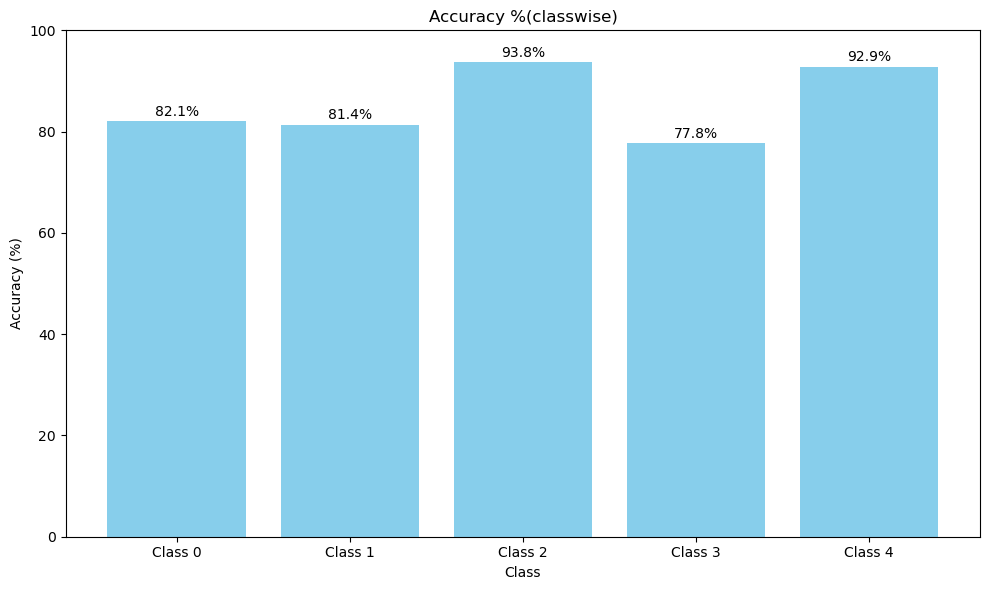

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def display_model_accuracy(model, val_generator):
    predictions = []
    true_labels = []
    
    for i in range(len(val_generator)):
        batch_images, batch_labels = val_generator[i]
        batch_predictions = model.predict(batch_images, verbose=0)
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels)
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(true_labels, axis=1)
    accuracy = accuracy_score(true_classes, pred_classes)
    print(f"\nOverall Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    classes = np.unique(true_classes)
    per_class_accuracy = []
    
    for c in classes:
        mask = true_classes == c
        class_accuracy = accuracy_score(true_classes[mask], pred_classes[mask])
        per_class_accuracy.append(class_accuracy)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(classes)), [acc * 100 for acc in per_class_accuracy], color='skyblue')  
    plt.ylim(0, 100)  
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy %(classwise)')
    plt.xticks(range(len(classes)), [f'Class {i}' for i in classes])

    for i, v in enumerate(per_class_accuracy):
        plt.text(i, v * 100 + 1, f'{v * 100:.1f}%', ha='center')  
    
    plt.tight_layout()
    plt.show()

display_model_accuracy(model, val_generator)